In [9]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from skimage.transform import rescale, resize, downscale_local_mean
fpath = "C:\\Users\maxim\OneDrive\Documents\master2\WSBIM2243\WSBIM2243\Dataset\\"

Patient ID.......: 
Image size.......: 4084 x 3328


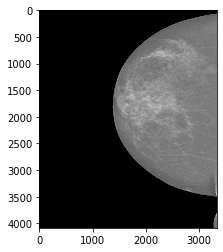

In [15]:
# Test ouverture fichier dicom
path = fpath+ "AllDICOMs\\" + "20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"
ds = dcmread(path)
pixels = ds.pixel_array

pat_name = ds.PatientName
print(f"Patient ID.......: {ds.PatientID}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
"""
display_name = pat_name.family_name + ", " + pat_name.given_name

print(f"Patient's Name...: {display_name}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
"""

plt.imshow(pixels, cmap=plt.cm.gray)

In [22]:
from roifile import *
path = fpath+ "AllROI\\" + "20586908.roi"
roi = ImagejRoi.fromfile(path)

ValueError: not an ImageJ ROI

In [24]:
from read_roi import read_roi_file
from read_roi import read_roi_zip
path = fpath+ "AllROI\\" + "20586908.roi"
roi = read_roi_file(path)

UnboundLocalError: local variable 'channel' referenced before assignment

In [63]:
from skimage.draw import polygon
import numpy as np
import plistlib

#https://gist.github.com/jendelel/3a8e768a8eb9345d49f2a82d02946122

def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            area = roi['Area']
            center = roi['Center']
            name = roi['Name']
            print(name,area)
            assert numPoints == len(points)
            
            points = [load_point(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[0]), int(point[1])] = 1
            else:
                x, y = zip(*points)
                x, y = np.array(x), np.array(y)
                poly_x, poly_y = polygon(x, y, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0022295000962913036
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.007533750031143427
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0012740000383928418
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Mass 0.42805787920951843
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0038219999987632036
<class 'float'>
Calcification 0.0
<class 'float'>
Calcification 0.0
<cla

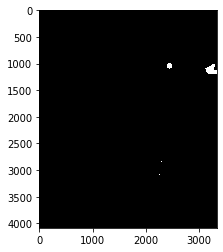

In [64]:
path = fpath+ "AllXML\\" + "20586908.xml"
mask = load_inbreast_mask(path)
plt.imshow(mask, cmap=plt.cm.gray)

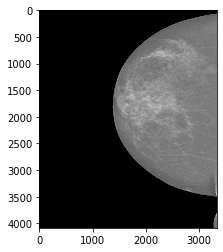

In [36]:
plt.imshow(pixels, cmap=plt.cm.gray)